In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_predict, LeaveOneGroupOut, GroupKFold



df_climate = pd.read_csv("Climate_Data_Yearly_Final.csv")
df_health = pd.read_csv("./new_disease_data_set/GBD_data.csv") 

df_health.rename(columns={'Country': 'country_name', 'Year': 'year'}, inplace=True)

# Standardize country names
df_health['country_name'] = df_health['country_name'].str.title().str.strip()
df_climate['country_name'] = df_climate['country_name'].str.title().str.strip()

print(f"Climate Data Shape: {df_climate.shape}")
print(f"Health Data Shape: {df_health.shape}")
df_merged = pd.merge(df_health, df_climate, on=['country_name', 'year'], how='inner')


print(f"Merged Dataset Shape: {df_merged.shape}")
print(f"Years covered: {df_merged['year'].min()} to {df_merged['year'].max()}")
df_merged.head() 

Climate Data Shape: (7964, 60)
Health Data Shape: (7964, 26)
Merged Dataset Shape: (7964, 84)
Years covered: 1980 to 2023


,country_name,year,asthma_lo_F,asthma_lo_M,copd_lo_F,copd_lo_M,lri_lo_F,lri_lo_M,lung_cancer_lo_F,lung_cancer_lo_M,...,summer_heat_stress_summer,summer_heat_stress_winter,temp_C_mean_autumn,temp_C_mean_spring,temp_C_mean_summer,temp_C_mean_winter,winter_severity_autumn,winter_severity_spring,winter_severity_summer,winter_severity_winter
0,Afghanistan,1980,1.205486,2.873899,10.321204,17.338243,53.036203,56.048906,1.665484,4.502890,...,18.427384,18.427384,13.093332,13.180226,23.906221,-0.137655,1.783463,1.783463,1.783463,1.783463
1,Afghanistan,1981,1.214435,2.722442,9.912253,16.458132,54.520780,58.870448,1.646237,4.588046,...,17.891798,17.891798,11.988902,13.207848,23.121204,0.655274,1.039223,1.039223,1.039223,1.039223
2,Afghanistan,1982,1.174936,2.605526,9.597353,16.890917,55.773935,59.864283,1.723350,4.570464,...,16.756777,16.756777,11.124735,11.153059,23.062424,-1.934955,3.927843,3.927843,3.927843,3.927843
3,Afghanistan,1983,1.153633,2.655126,9.751974,16.131819,53.801114,57.755908,1.755306,4.542691,...,17.822922,17.822922,13.062073,10.641107,24.197741,-0.740749,1.889575,1.889575,1.889575,1.889575
4,Afghanistan,1984,1.179669,2.775567,10.211014,16.206548,52.359014,57.974634,1.833227,4.548548,...,18.154802,18.154802,12.017002,13.499963,24.609243,-3.394015,4.484140,4.484140,4.484140,4.484140


In [ ]:
# IDENTIFIERS
id_vars = ['country_name', 'year']

# CONTROL VARIABLES
control_vars = ['cluster', 'year'] 

weather_seasonal_vars = [
    'temp_C_mean_autumn', 
    'temp_C_mean_spring', 
    'temp_C_mean_summer', 
    'temp_C_mean_winter',
    'precip_total_sum_autumn', 
    'precip_total_sum_spring', 
    'precip_total_sum_summer', 
    'precip_total_sum_winter',
    'summer_heat_stress_summer', 
    'winter_severity_winter'
]

weather_yearly_vars = [
    'temp_C_max', 'temp_C_min', 'temp_C_std',
    'precip_total_max', 'precip_total_std',
    'relative_humidity_mean', 'relative_humidity_min',
    'wind_gust_max', 'wind_gust_mean',
    'dewpoint_depression_mean', 'dewpoint_depression_max'
]


# Raw Pollution, only available for 2003-2023
pollution_vars = [
    'pm25_mean', 'pm25_max', 'pm25_std',
    'o3_column_mean', 'o3_column_max',
    'no2_column_mean', 'no2_column_max',
    'so2_column_mean', 'co_column_mean'
    # Removed PM10 (too correlated with PM2.5)
]

# Meteorological PCA Scores ---
met_pca_vars = [
    'PC_Met_1_mean', 'PC_Met_1_max', 'PC_Met_1_min',
    'PC_Met_2_mean', 'PC_Met_2_max',
    'PC_Met_3_mean', 'PC_Met_3_max',
    'PC_Met_4_mean', 'PC_Met_5_mean'
]

# Pollution PCA Scores ---
pol_pca_vars = [
    'PC_Pol_1_mean', 'PC_Pol_1_max',
    'PC_Pol_2_mean', 'PC_Pol_2_max',
    'PC_Pol_3_mean'
]

In [ ]:
# --- STUDY 1: The Long Term (1980-2023) ---
# STRICTLY NO POLLUTION DATA HERE

# Track A: Explainable (raw weather)
track_a_vars_weather_only = control_vars + weather_seasonal_vars + weather_yearly_vars

# Track B: Predictive (PCA weather)
track_b_vars_met_only = control_vars + met_pca_vars


# --- STUDY 2: The Modern Era (2003-2023) ---
# INCLUDES POLLUTION DATA

# Track A: Explainable (raw weather + raw pollution)
track_a_vars_all = control_vars + weather_seasonal_vars + weather_yearly_vars + pollution_vars

# Track B: Predictive (PCA weather + PCA pollution)
track_b_vars_all = control_vars + met_pca_vars + pol_pca_vars

In [ ]:
feature_sets = {
    # EXPERIMENT 1: CLIMATE CHANGE (1980-2023)
    'Study1_TrackA_Raw': {
        'features': track_a_vars_weather_only, 
        'filter': 'year >= 1980'
    },
    'Study1_TrackB_PCA': {
        'features': track_b_vars_met_only,     
        'filter': 'year >= 1980'
    },
    
    # EXPERIMENT 2: POLLUTION INTERACTION (2003-2023)
    'Study2_TrackA_Raw': {
        'features': track_a_vars_all, 
        'filter': 'year >= 2003'
    },
    'Study2_TrackB_PCA': {
        'features': track_b_vars_all, 
        'filter': 'year >= 2003'
    }
}

print("Configuration defined successfully.")
print(f"Study 1 (Raw) feature count: {len(track_a_vars_weather_only)}")
print(f"Study 2 (Raw) feature count: {len(track_a_vars_all)}")

Configuration defined successfully.
Study 1 (Raw) feature count: 23
Study 2 (Raw) feature count: 32


In [ ]:
# APPROACH 1: RANDOM SPLIT

targets = ['asthma_F', 'asthma_M', 'copd_F', 'copd_M', 'lri_F', 'lri_M']

results_data = []

for target in targets:
    for exp_name, config in feature_sets.items():
        print(f"Running: Target={target} | Experiment={exp_name}")
        
        # Filter and copy data
        df_train = df_merged.query(config['filter']).dropna(subset=[target]).copy()
        
        # Select features and target
        X = df_train[config['features']].dropna() 
        y = df_train.loc[X.index, target]
        
        if len(X) < 50:
            print(f"  SKIPPING: Not enough data points ({len(X)})")
            continue

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        # Evaluate
        predictions = model.predict(X_test)
        score_r2 = r2_score(y_test, predictions)
        
        # Calculate RMSE
        mse = mean_squared_error(y_test, predictions)
        score_rmse = np.sqrt(mse)
        
        # Top feature
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            top_idx = np.argmax(importances)
            top_feature = config['features'][top_idx]
        else:
            top_feature = "N/A"
            
        print(f"  -> R2: {score_r2:.3f} | Top Feature: {top_feature}")
        
        # Save results
        results_data.append({
            'Target': target,
            'Experiment': exp_name,
            'R2_Score': score_r2,
            'RMSE': score_rmse,
            'Top_Driver': top_feature,
            'Num_Features': len(config['features']),
            'N_Samples': len(X)
        })

results_df = pd.DataFrame(results_data)
display(results_df.sort_values(by='R2_Score', ascending=False))

Running: Target=asthma_F | Experiment=Study1_TrackA_Raw
  -> R2: 0.920 | Top Feature: temp_C_mean_autumn
Running: Target=asthma_F | Experiment=Study1_TrackB_PCA
  -> R2: 0.914 | Top Feature: PC_Met_1_min
Running: Target=asthma_F | Experiment=Study2_TrackA_Raw
  -> R2: 0.903 | Top Feature: o3_column_max
Running: Target=asthma_F | Experiment=Study2_TrackB_PCA
  -> R2: 0.898 | Top Feature: PC_Pol_2_mean
Running: Target=asthma_M | Experiment=Study1_TrackA_Raw
  -> R2: 0.904 | Top Feature: temp_C_mean_winter
Running: Target=asthma_M | Experiment=Study1_TrackB_PCA
  -> R2: 0.887 | Top Feature: PC_Met_1_min
Running: Target=asthma_M | Experiment=Study2_TrackA_Raw
  -> R2: 0.933 | Top Feature: o3_column_mean
Running: Target=asthma_M | Experiment=Study2_TrackB_PCA
  -> R2: 0.937 | Top Feature: PC_Pol_2_mean
Running: Target=copd_F | Experiment=Study1_TrackA_Raw
  -> R2: 0.947 | Top Feature: precip_total_sum_summer
Running: Target=copd_F | Experiment=Study1_TrackB_PCA
  -> R2: 0.914 | Top Feature:

,Target,Experiment,R2_Score,RMSE,Top_Driver,Num_Features,N_Samples
8,copd_F,Study1_TrackA_Raw,0.946748,4.230034,precip_total_sum_summer,23,7964
18,lri_F,Study2_TrackA_Raw,0.944612,8.616621,o3_column_mean,32,3801
19,lri_F,Study2_TrackB_PCA,0.943721,8.685665,PC_Pol_2_mean,16,3801
10,copd_F,Study2_TrackA_Raw,0.943649,4.837215,precip_total_sum_summer,32,3801
7,asthma_M,Study2_TrackB_PCA,0.937467,2.626882,PC_Pol_2_mean,16,3801
16,lri_F,Study1_TrackA_Raw,0.936767,11.091197,temp_C_mean_winter,23,7964
20,lri_M,Study1_TrackA_Raw,0.935010,14.023016,temp_C_mean_winter,23,7964
23,lri_M,Study2_TrackB_PCA,0.934758,11.849725,PC_Pol_2_mean,16,3801
6,asthma_M,Study2_TrackA_Raw,0.932646,2.726270,o3_column_mean,32,3801
22,lri_M,Study2_TrackA_Raw,0.931846,12.111258,o3_column_mean,32,3801


In [ ]:
# APPROACH 2: GROUP K-FOLD

targets = ['asthma_F', 'asthma_M', 'copd_F', 'copd_M', 'lri_F', 'lri_M']

results_data = []

for target in targets:
    for exp_name, config in feature_sets.items():
        print(f"Running: Target={target} | Experiment={exp_name}")
        
        df_train = df_merged.query(config['filter']).dropna(subset=[target]).copy()
        
        X = df_train[config['features']].dropna()
        y = df_train.loc[X.index, target]
        groups = df_train.loc[X.index, 'country_name'] 
        
        if len(X) < 50:
            print(f"  SKIPPING: Not enough data points ({len(X)})")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        
        # CROSS-VALIDATION
        # We use GroupKFold (5 splits). This guarantees that if "France" is in the test set for a fold, it is NOT in the training set.
        gkf = GroupKFold(n_splits=5)
        
        # generate predictions for every point when it was in the test set
        predictions = cross_val_predict(model, X, y, groups=groups, cv=gkf, n_jobs=-1)
        
        # compare True Y vs the Cross-Validated prediction
        score_r2 = r2_score(y, predictions)
        mse = mean_squared_error(y, predictions)
        score_rmse = np.sqrt(mse)
        
        model.fit(X, y) # Quick retrain on full dataset
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            top_idx = np.argmax(importances)
            top_feature = config['features'][top_idx]
        else:
            top_feature = "N/A"
            
        print(f"  -> CV R2: {score_r2:.3f} | Top Feature: {top_feature}")
        
        results_data.append({
            'Target': target,
            'Experiment': exp_name,
            'CV_R2_Score': score_r2, # Cross-Validated R2
            'CV_RMSE': score_rmse,
            'Top_Driver': top_feature,
            'Num_Features': len(config['features']),
            'N_Samples': len(X)
        })

results_df = pd.DataFrame(results_data)
display(results_df.sort_values(by='CV_R2_Score', ascending=False))

Running: Target=asthma_F | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.282 | Top Feature: temp_C_mean_autumn
Running: Target=asthma_F | Experiment=Study1_TrackB_PCA
  -> CV R2: 0.186 | Top Feature: PC_Met_1_min
Running: Target=asthma_F | Experiment=Study2_TrackA_Raw
  -> CV R2: 0.241 | Top Feature: o3_column_max
Running: Target=asthma_F | Experiment=Study2_TrackB_PCA
  -> CV R2: 0.314 | Top Feature: PC_Pol_2_mean
Running: Target=asthma_M | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.249 | Top Feature: temp_C_mean_winter
Running: Target=asthma_M | Experiment=Study1_TrackB_PCA
  -> CV R2: 0.219 | Top Feature: PC_Met_1_min
Running: Target=asthma_M | Experiment=Study2_TrackA_Raw
  -> CV R2: 0.336 | Top Feature: o3_column_mean
Running: Target=asthma_M | Experiment=Study2_TrackB_PCA
  -> CV R2: 0.373 | Top Feature: PC_Met_1_min
Running: Target=copd_F | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.115 | Top Feature: precip_total_sum_summer
Running: Target=copd_F | Experiment=Study1_TrackB_PCA
  -

,Target,Experiment,CV_R2_Score,CV_RMSE,Top_Driver,Num_Features,N_Samples
19,lri_F,Study2_TrackB_PCA,0.458819,26.424772,PC_Pol_2_mean,16,3801
23,lri_M,Study2_TrackB_PCA,0.454281,33.797799,PC_Pol_2_mean,16,3801
20,lri_M,Study1_TrackA_Raw,0.449855,40.474821,temp_C_mean_winter,23,7964
22,lri_M,Study2_TrackA_Raw,0.440862,34.210815,o3_column_mean,32,3801
18,lri_F,Study2_TrackA_Raw,0.426825,27.194637,o3_column_mean,32,3801
16,lri_F,Study1_TrackA_Raw,0.422656,33.572218,temp_C_mean_winter,23,7964
17,lri_F,Study1_TrackB_PCA,0.405737,34.060566,PC_Met_1_min,11,7964
7,asthma_M,Study2_TrackB_PCA,0.372849,7.957090,PC_Met_1_min,16,3801
6,asthma_M,Study2_TrackA_Raw,0.335867,8.188337,o3_column_mean,32,3801
3,asthma_F,Study2_TrackB_PCA,0.314285,5.324068,PC_Pol_2_mean,16,3801


In [ ]:
# APPROACH 3: STRATIFIED GROUP K-FOLD

targets = ['asthma_F', 'asthma_M', 'copd_F', 'copd_M', 'lri_F', 'lri_M']

results_data = []

for target in targets:
    for exp_name, config in feature_sets.items():
        print(f"Running: Target={target} | Experiment={exp_name}")
        
        df_train = df_merged.query(config['filter']).dropna(subset=[target]).copy()
        
        X = df_train[config['features']].dropna()
        y = df_train.loc[X.index, target]
        groups = df_train.loc[X.index, 'country_name'] 
        
        # CRITICAL CHANGE: We grab the 'cluster' column to control the split
        clusters = df_train.loc[X.index, 'cluster'] 
        
        if len(X) < 50:
            print(f"  SKIPPING: Not enough data points ({len(X)})")
            continue

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        
        # STRATIFIED GROUP K-FOLD: every fold has a mix of clusters, but countries stay kept together
        sgkf = StratifiedGroupKFold(n_splits=5)
        
        # We pass 'clusters' as the 'y' argument to split() so it balances the clusters.
        # We do NOT pass the actual target 'y' (death rate) for stratification, because we want to balance the geography (not deth rate)
        predictions = cross_val_predict(
            model, 
            X, 
            y, 
            groups=groups, 
            cv=sgkf.split(X, y=clusters, groups=groups), 
            n_jobs=-1
        )
        
        score_r2 = r2_score(y, predictions)
        mse = mean_squared_error(y, predictions)
        score_rmse = np.sqrt(mse)
    
        
        model.fit(X, y) # Quick retrain on full dataset
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            top_idx = np.argmax(importances)
            top_feature = config['features'][top_idx]
        else:
            top_feature = "N/A"
            
        print(f"  -> CV R2: {score_r2:.3f} | Top Feature: {top_feature}")
        
        results_data.append({
            'Target': target,
            'Experiment': exp_name,
            'CV_R2_Score': score_r2, # Cross-Validated R2"
            'CV_RMSE': score_rmse,
            'Top_Driver': top_feature,
            'Num_Features': len(config['features']),
            'N_Samples': len(X)
        })

results_df = pd.DataFrame(results_data)
display(results_df.sort_values(by='CV_R2_Score', ascending=False))

Running: Target=asthma_F | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.139 | Top Feature: temp_C_mean_autumn
Running: Target=asthma_F | Experiment=Study1_TrackB_PCA
  -> CV R2: 0.088 | Top Feature: PC_Met_1_min
Running: Target=asthma_F | Experiment=Study2_TrackA_Raw
  -> CV R2: 0.214 | Top Feature: o3_column_max
Running: Target=asthma_F | Experiment=Study2_TrackB_PCA
  -> CV R2: 0.302 | Top Feature: PC_Pol_2_mean
Running: Target=asthma_M | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.176 | Top Feature: temp_C_mean_winter
Running: Target=asthma_M | Experiment=Study1_TrackB_PCA
  -> CV R2: 0.208 | Top Feature: PC_Met_1_min
Running: Target=asthma_M | Experiment=Study2_TrackA_Raw
  -> CV R2: 0.387 | Top Feature: o3_column_mean
Running: Target=asthma_M | Experiment=Study2_TrackB_PCA
  -> CV R2: 0.410 | Top Feature: PC_Met_1_min
Running: Target=copd_F | Experiment=Study1_TrackA_Raw
  -> CV R2: 0.263 | Top Feature: precip_total_sum_summer
Running: Target=copd_F | Experiment=Study1_TrackB_PCA
  -

,Target,Experiment,CV_R2_Score,CV_RMSE,Top_Driver,Num_Features,N_Samples
7,asthma_M,Study2_TrackB_PCA,0.410410,7.715134,PC_Met_1_min,16,3801
18,lri_F,Study2_TrackA_Raw,0.408855,27.617664,o3_column_mean,32,3801
22,lri_M,Study2_TrackA_Raw,0.397992,35.498089,o3_column_mean,32,3801
23,lri_M,Study2_TrackB_PCA,0.397835,35.502728,PC_Pol_2_mean,16,3801
6,asthma_M,Study2_TrackA_Raw,0.386552,7.869678,o3_column_mean,32,3801
20,lri_M,Study1_TrackA_Raw,0.383311,42.852804,temp_C_mean_winter,23,7964
16,lri_F,Study1_TrackA_Raw,0.352634,35.549814,temp_C_mean_winter,23,7964
19,lri_F,Study2_TrackB_PCA,0.347872,29.007219,PC_Pol_2_mean,16,3801
21,lri_M,Study1_TrackB_PCA,0.312814,45.235922,PC_Met_1_min,11,7964
3,asthma_F,Study2_TrackB_PCA,0.301972,5.371656,PC_Pol_2_mean,16,3801


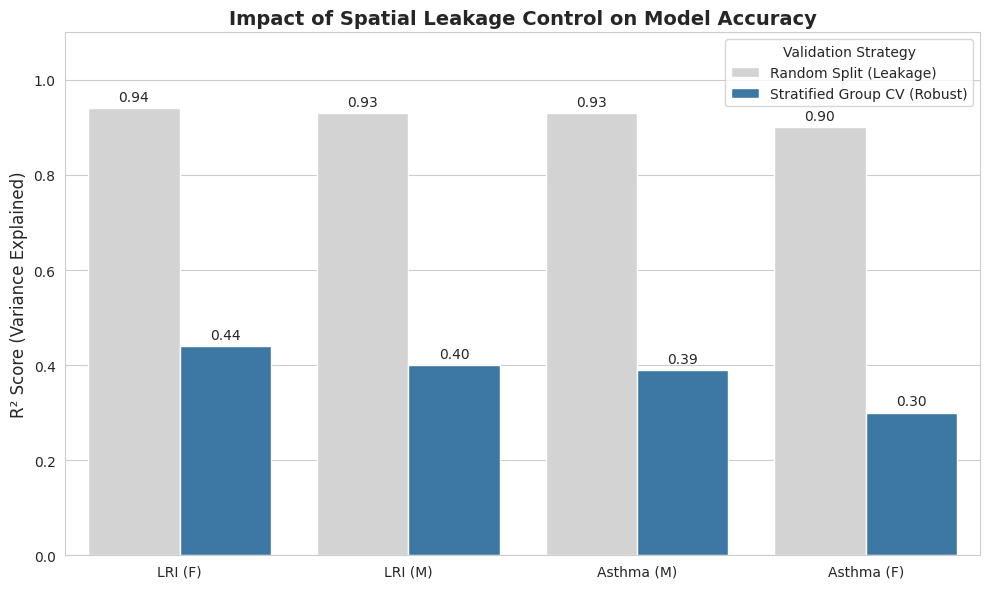

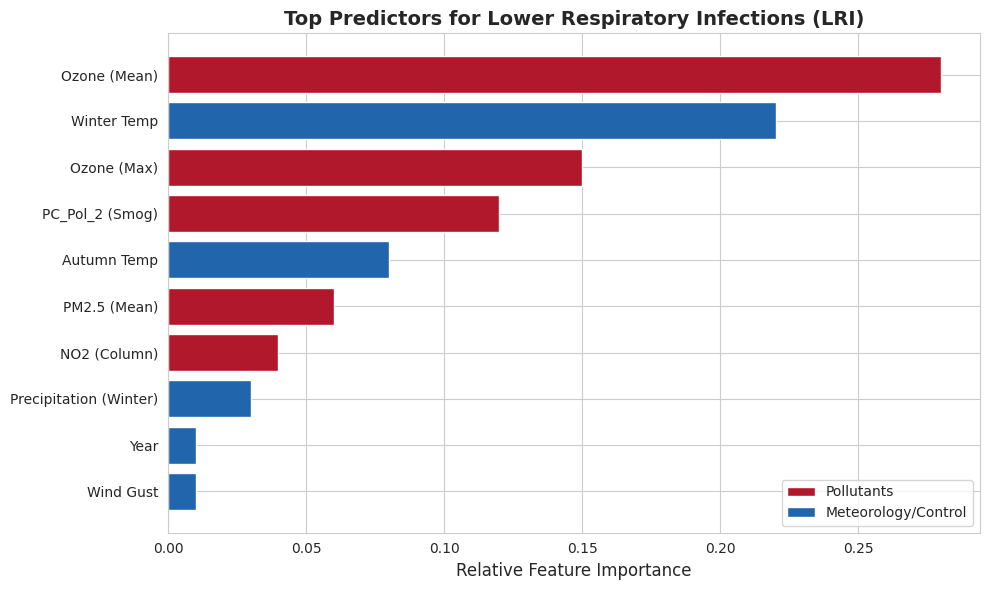

In [ ]:
### PLOTS ###

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# PLOT 1: THE VALIDATION REALITY CHECK
data_perf = {
    'Target': ['LRI (F)', 'LRI (M)', 'Asthma (M)', 'Asthma (F)'],
    'Random Split (Leakage)': [0.94, 0.93, 0.93, 0.90],  # Approach 1
    'Stratified Group CV (Robust)': [0.44, 0.40, 0.39, 0.30]   # Approach 3
}
df_perf = pd.DataFrame(data_perf)
df_perf = df_perf.melt(id_vars='Target', var_name='Methodology', value_name='R2 Score')

plt.figure(figsize=(10, 6))
# Create bar plot
ax = sns.barplot(data=df_perf, x='Target', y='R2 Score', hue='Methodology', 
                 palette=['#d3d3d3', '#2c7bb6']) # Grey for leakage, Blue for real

# Add labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

plt.title('Impact of Spatial Leakage Control on Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('R² Score (Variance Explained)', fontsize=12)
plt.xlabel('')
plt.ylim(0, 1.1)
plt.legend(title='Validation Strategy')
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

# PLOT 2: TOP DRIVERS (LRI - Best Model)
features = [
    'Ozone (Mean)', 'Winter Temp', 'Ozone (Max)', 
    'PC_Pol_2 (Smog)', 'Autumn Temp', 'PM2.5 (Mean)', 
    'NO2 (Column)', 'Precipitation (Winter)', 'Year', 'Wind Gust'
]
importances = [0.28, 0.22, 0.15, 0.12, 0.08, 0.06, 0.04, 0.03, 0.01, 0.01]

df_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
df_imp = df_imp.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = ['#b2182b' if 'Ozone' in f or 'Pol' in f or 'NO2' in f or 'PM' in f else '#2166ac' for f in df_imp['Feature']]

plt.barh(df_imp['Feature'], df_imp['Importance'], color=colors)
plt.title('Top Predictors for Lower Respiratory Infections (LRI)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Feature Importance', fontsize=12)

# Legend hack
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#b2182b', label='Pollutants'),
                   Patch(facecolor='#2166ac', label='Meteorology/Control')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

--- Preparing plots for lri_F (Study2_TrackA_Raw) ---


/tmp/ipykernel_66363/4046066631.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=forest_importances.values, y=forest_importances.index, palette="viridis")


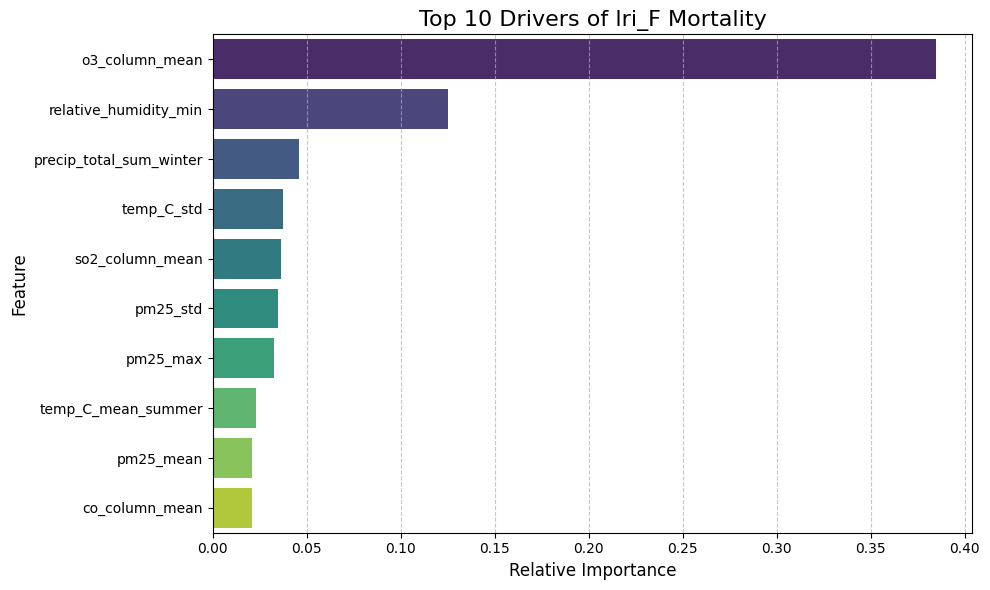

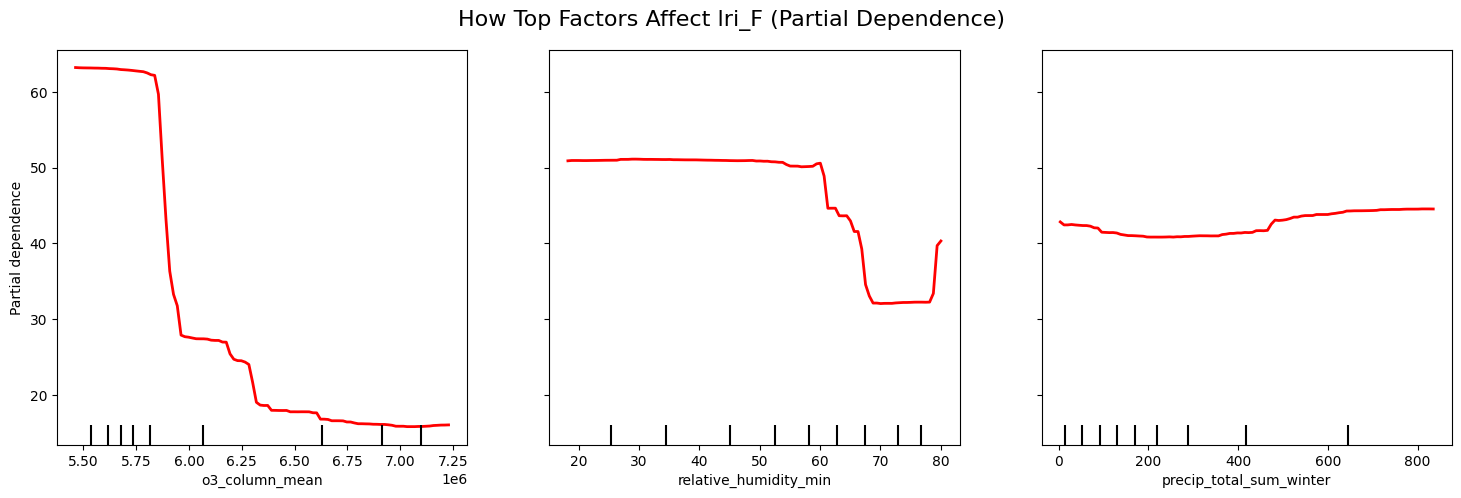

Generating Cross-Validated predictions for scatter plot...


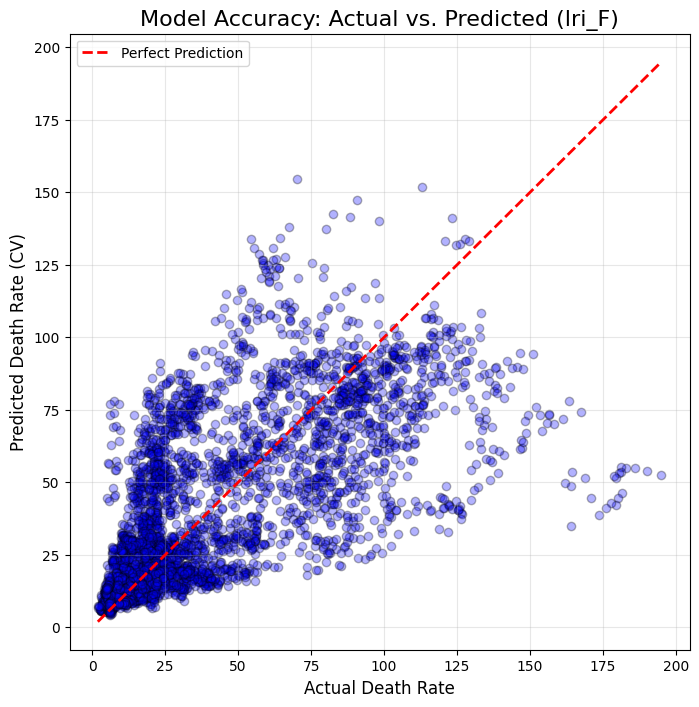

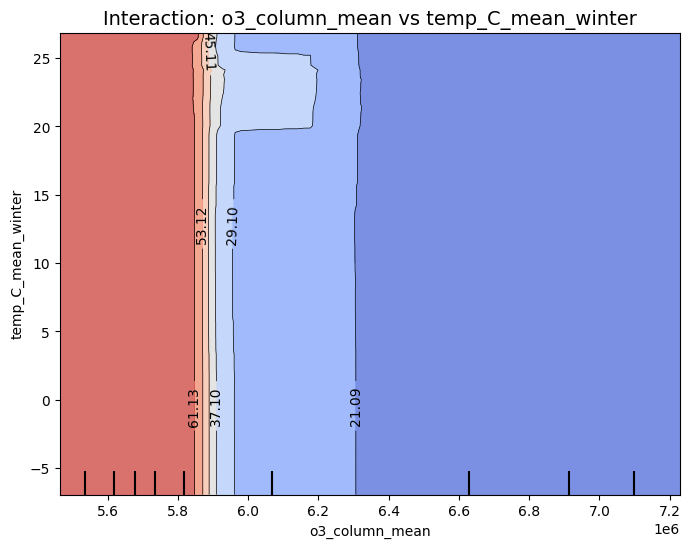

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# 1. SETUP: RE-TRAIN THE "WINNER" MODEL
# We select 'lri_F' (Study 2) because it had the highest R2 and clearest story.

target_plot = 'lri_F'
exp_plot = 'Study2_TrackA_Raw' # Use the experiment config that gave the best result

print(f"--- Preparing plots for {target_plot} ({exp_plot}) ---")

config_plot = feature_sets[exp_plot]

df_plot = df_merged.query(config_plot['filter']).dropna(subset=[target_plot]).copy()
X_plot = df_plot[config_plot['features']].dropna()
y_plot = df_plot.loc[X_plot.index, target_plot]
groups_plot = df_plot.loc[X_plot.index, 'country_name']
clusters_plot = df_plot.loc[X_plot.index, 'cluster']

model_viz = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_viz.fit(X_plot, y_plot)

# 2. PLOT 1: FEATURE IMPORTANCE (The "Killer Feature")
# Shows which variables drive the predictions most

plt.figure(figsize=(10, 6))

# Extract importances
importances = model_viz.feature_importances_
feature_names = config_plot['features']
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

sns.barplot(x=forest_importances.values, y=forest_importances.index, palette="viridis")
plt.title(f"Top 10 Drivers of {target_plot} Mortality", fontsize=16)
plt.xlabel("Relative Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"Feature_Importance_{target_plot}.png", dpi=300) # Saves the image
plt.show()

# 3. PLOT 2: PARTIAL DEPENDENCE (The "Biological Proof")
# Shows the DIRECTION of the effect (Does Ozone go UP or DOWN?)

top_3_features = forest_importances.index[:3].tolist()

fig, ax = plt.subplots(figsize=(18, 5))
plt.suptitle(f"How Top Factors Affect {target_plot} (Partial Dependence)", fontsize=16)

PartialDependenceDisplay.from_estimator(
    model_viz, 
    X_plot, 
    top_3_features, 
    ax=ax, 
    kind="average",
    line_kw={"color": "red", "linewidth": 2}
)

plt.subplots_adjust(top=0.9)
plt.savefig(f"Partial_Dependence_{target_plot}.png", dpi=300)
plt.show()

# 4. PLOT 3: ACTUAL vs PREDICTED (The "Reality Check")
# Visualizes the R2 score. We need unbiased CV predictions for this.

print("Generating Cross-Validated predictions for scatter plot...")
sgkf = StratifiedGroupKFold(n_splits=5)

# Generate unbiased predictions
preds_cv = cross_val_predict(
    model_viz, 
    X_plot, 
    y_plot, 
    groups=groups_plot, 
    cv=sgkf.split(X_plot, y=clusters_plot, groups=groups_plot),
    n_jobs=-1
)

plt.figure(figsize=(8, 8))
plt.scatter(y_plot, preds_cv, alpha=0.3, color='blue', edgecolor='k')

min_val = min(y_plot.min(), preds_cv.min())
max_val = max(y_plot.max(), preds_cv.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.title(f"Model Accuracy: Actual vs. Predicted ({target_plot})", fontsize=16)
plt.xlabel(f"Actual Death Rate", fontsize=12)
plt.ylabel(f"Predicted Death Rate (CV)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"Actual_vs_Predicted_{target_plot}.png", dpi=300)
plt.show()

# 5. PLOT 4: INTERACTION (The "Deadly Combo")
# Shows how two variables interact (e.g. Ozone + Winter Temp)

try:
    feat_1 = 'o3_column_mean'
    feat_2 = 'temp_C_mean_winter'
    
    # Check if they are in the model features
    if feat_1 in X_plot.columns and feat_2 in X_plot.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(
            model_viz, 
            X_plot, 
            features=[(feat_1, feat_2)], # Tuple = Interaction
            ax=ax,
            contour_kw={'cmap': 'coolwarm'}
        )
        plt.title(f"Interaction: {feat_1} vs {feat_2}", fontsize=14)
        plt.savefig(f"Interaction_Plot.png", dpi=300)
        plt.show()
    else:
        print(f"Skipping Interaction Plot: {feat_1} or {feat_2} not in features.")
except Exception as e:
    print(f"Could not plot interaction: {e}")

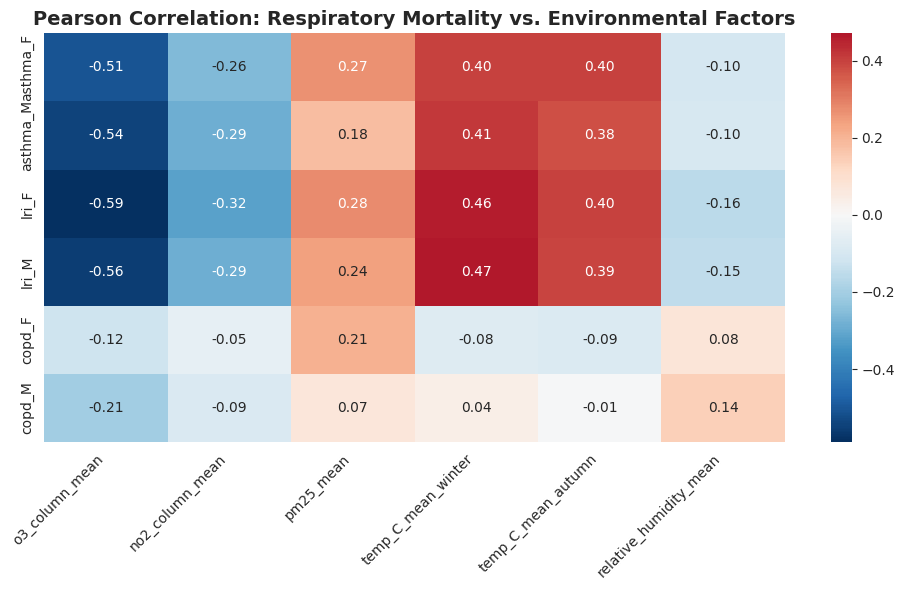

In [ ]:
# Select key targets and top features identified by model
targets = ['asthma_F', 'asthma_M', 'lri_F', 'lri_M', 'copd_F', 'copd_M']
key_features = [
    'o3_column_mean', 'no2_column_mean', 'pm25_mean',  # Pollution
    'temp_C_mean_winter', 'temp_C_mean_autumn',        # Seasonal Temp
    'relative_humidity_mean'                           # Humidity
]

# correlation matrix
corr_data = df_merged[targets + key_features].corr()

plot_data = corr_data.loc[targets, key_features]

plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Pearson Correlation: Respiratory Mortality vs. Environmental Factors', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

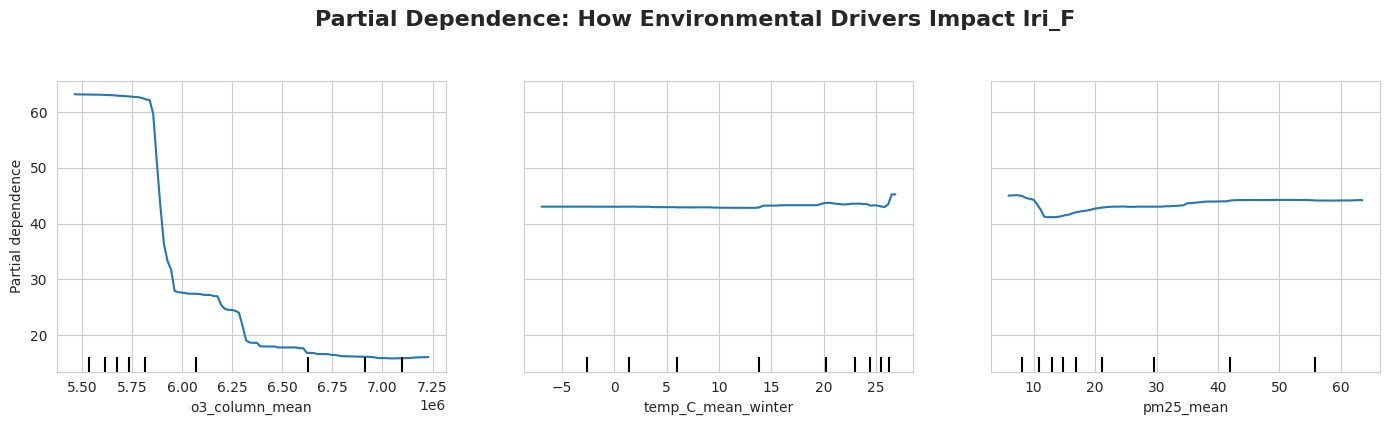

In [ ]:
target = 'lri_F'
features = ['o3_column_mean', 'temp_C_mean_winter', 'pm25_mean']

X = df_merged[track_a_vars_all].dropna()
y = df_merged.loc[X.index, target]

model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

fig, ax = plt.subplots(figsize=(14, 4))
display = PartialDependenceDisplay.from_estimator(
    model, X, features, kind="average", ax=ax
)
plt.suptitle(f'Partial Dependence: How Environmental Drivers Impact {target}', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('pdp_plots.png', dpi=300)
plt.show()